In [52]:
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision.models import resnet18
import pickle
import os
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from sklearn.decomposition import PCA
from openood.evaluation_api import Evaluator
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #32x32 -> 40x40 -> 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #PIL to tensor
    transforms.Normalize(#apprently help to converge.
        mean=[0.5071, 0.4867, 0.4408], 
        std=[0.2675, 0.2565, 0.2761]
    ),
])#help the model to be more robust

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761] #necessary to have the same kind of data for evaluation
    ),
])

In [6]:

trainset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

testset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=8)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
model = resnet18(weights=None)  # pas ImageNet pretrained

#H_out = (H + 2p − k) / s + 1
#Donc sans toucher H_out = (32 + 2x3 - 7) / 2  + 1 = 16 
#Puis avec le max pool on tombe à 8. 
# Très génant car les canaux stocknte des motifs mais pas la position, donc en passant de 32 à 8 on "flouterai" enormement l'image

# Modifie la première couche pour prendre du 32x32
model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
model.maxpool = nn.Identity() #out = 64x32x32 bien mieux que 64x8x8

# Modifier la dernière couche pour avoir 100 classes
model.fc = nn.Linear(512, 100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

Device: cuda


In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0015, #0.005 -> 0.003 -> 0.0015
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[70, 80],
    gamma=0.1
)

In [9]:
def train_one_epoch(model, loader):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    return running_loss / len(loader), acc


In [11]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return 100. * correct / total

In [12]:
checkpoint = torch.load("checkpoints/best.pth")

model.load_state_dict(checkpoint["model_state"])
#optimizer.load_state_dict(checkpoint["optimizer_state"])
#scheduler.load_state_dict(checkpoint["scheduler_state"])

start_epoch = checkpoint["epoch"]
model = model.to(device)

C:\Users\mathi\AppData\Local\Temp\ipykernel_9552\67857274.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/best.pth")


In [13]:
model = model.to(device)

train_losses = checkpoint["train_losses"]
train_accs = checkpoint["train_accs"]
test_accs = checkpoint["test_accs"]

In [28]:
train_accs, test_accs, train_losses = [], [], []

In [63]:
num_epochs = 200

save_every = 10
os.makedirs("checkpoints", exist_ok=True)
torch.backends.cudnn.benchmark = True
best_acc = -1.0

for epoch in range(start_epoch, num_epochs):
    train_loss, train_acc = train_one_epoch(model, trainloader)
    test_acc = evaluate(model, testloader)
    scheduler.step()

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)

    if test_acc > best_acc:
        checkpoint = {
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "train_losses": train_losses,
            "train_accs": train_accs,
            "test_accs": test_accs,
        }
        best_acc = test_acc
        torch.save(checkpoint, "checkpoints/best.pth")
    #sauvegarde périodique
    if (epoch + 1) % save_every == 0:
        checkpoint = {
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "train_losses": train_losses,
            "train_accs": train_accs,
            "test_accs": test_accs,
        }
        torch.save(checkpoint, f"checkpoints/checkpoint_epoch_{epoch+1}.pth")

    print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

torch.save(model.state_dict(), "resnet18_cifar100.pth")

history = {
    "train_losses": train_losses,
    "train_accs": train_accs,
    "test_accs": test_accs
}

with open("training_history.pkl", "wb") as f:
    pickle.dump(history, f)

Epoch 082 | Train Acc: 99.96% | Test Acc: 76.02%
Epoch 083 | Train Acc: 99.97% | Test Acc: 75.99%
Epoch 084 | Train Acc: 99.96% | Test Acc: 76.13%
Epoch 085 | Train Acc: 99.96% | Test Acc: 76.13%
Epoch 086 | Train Acc: 99.96% | Test Acc: 76.31%
Epoch 087 | Train Acc: 99.96% | Test Acc: 76.24%
Epoch 088 | Train Acc: 99.97% | Test Acc: 76.32%
Epoch 089 | Train Acc: 99.95% | Test Acc: 76.28%
Epoch 090 | Train Acc: 99.97% | Test Acc: 76.32%
Epoch 091 | Train Acc: 99.96% | Test Acc: 76.20%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001848601D2D0>
Traceback (most recent call last):
  File "c:\Users\mathi\miniconda3\envs\ME\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\mathi\miniconda3\envs\ME\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001848601D2D0>
Traceback (most recent call last):
  File "c:\Users\mathi\miniconda3\envs\ME\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\mathi\miniconda3\envs\ME\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._work

KeyboardInterrupt: 

In [14]:
checkpoint = torch.load("checkpoints/best.pth")

model.load_state_dict(checkpoint["model_state"])
model.eval().to(device)

C:\Users\mathi\AppData\Local\Temp\ipykernel_9552\1937691237.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/best.pth")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [15]:
preprocessor = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

In [ ]:

methods = [
    "energy",
    "odin",
    "maxlogit"
]

all_metrics = {}

for m in methods:
    evaluator = Evaluator(
        net=model,
        id_name="cifar100",          
        preprocessor=preprocessor,  
        postprocessor_name=m
    )
    metrics = evaluator.eval_ood()  
    all_metrics[m] = metrics
    print(m, metrics) 
    #OpenOOD n'est pas à jour, les liens ont changés

HTTPError: HTTP Error 404: Not Found

In [40]:
ood_cifar10 = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

ood_svhn = torchvision.datasets.SVHN(
    root="./data",
    split="test",
    download=True,
    transform=transform_test
)

ood_cifar10_loader = DataLoader(ood_cifar10, batch_size=256, shuffle=False, num_workers=8)
ood_svhn_loader = DataLoader(ood_svhn, batch_size=256, shuffle=False, num_workers=8)

testset_q3 = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    transform=transform_test
)
testloader_q3 = DataLoader(testset_q3, batch_size=256, shuffle=False, num_workers=8)

# TRAIN (pour stats seulement, sans augmentation)
trainset_q3 = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    transform=transform_test  
)
trainloader_q3 = DataLoader(trainset_q3, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Using downloaded and verified file: ./data\test_32x32.mat


In [26]:
@torch.no_grad()
def collect_logits(model, loader):
    logits = []
    for x, _ in loader:
        x = x.to(device)
        logits.append(model(x).cpu())
    return torch.cat(logits)


In [27]:
@torch.no_grad()
def collect_features(model, loader):
    feats = []
    for x, _ in loader:
        x = x.to(device)

        z = model.conv1(x)
        z = model.bn1(z)
        z = model.relu(z)
        z = model.maxpool(z)
        z = model.layer1(z)
        z = model.layer2(z)
        z = model.layer3(z)
        z = model.layer4(z)
        z = model.avgpool(z)
        z = torch.flatten(z, 1)

        feats.append(z.cpu())

    return torch.cat(feats)

In [28]:
def score_msp(logits):
    return (-F.softmax(logits, dim=1).max(dim=1).values).numpy()

In [29]:
def score_maxlogit(logits):
    return (-logits.max(dim=1).values).numpy()

In [30]:
def score_energy(logits):
    return (-torch.logsumexp(logits, dim=1)).numpy()

In [31]:
def fit_mahalanobis(features, labels, num_classes=100):
    X = features.numpy()
    y = labels.numpy()

    dim = X.shape[1]
    mus = np.zeros((num_classes, dim))

    for c in range(num_classes):
        mus[c] = X[y == c].mean(axis=0)

    Xc = X - mus[y]
    cov = np.cov(Xc, rowvar=False)
    cov += 1e-4 * np.eye(dim)
    inv_cov = np.linalg.inv(cov)

    return mus, inv_cov

In [32]:
def score_mahalanobis(features, mus, inv_cov):
    X = features.numpy()
    dists = []
    for c in range(mus.shape[0]):
        diff = X - mus[c]
        d = np.einsum("nd,dd,nd->n", diff, inv_cov, diff)
        dists.append(d)
    return np.min(np.stack(dists, axis=1), axis=1)

In [34]:
def fit_vim(train_feats, dim=64):
    pca = PCA(n_components=dim)
    pca.fit(train_feats)
    U = pca.components_
    U_orth = np.eye(train_feats.shape[1]) - U.T @ U
    return U_orth

In [35]:
def score_vim(logits, features, U_orth, alpha=1.0):
    energy = score_energy(logits)
    proj = np.linalg.norm(features.numpy() @ U_orth, axis=1)
    return energy + alpha * proj

In [36]:
def fpr_at_95(y, s):
    fpr, tpr, _ = roc_curve(y, s)
    return fpr[np.argmin(np.abs(tpr - 0.95))]

def eval_ood(id_scores, ood_scores):
    y = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
    s = np.concatenate([id_scores, ood_scores])
    return {
        "AUROC": roc_auc_score(y, s),
        "AUPR": average_precision_score(y, s),
        "FPR@95": fpr_at_95(y, s),
    }

In [37]:
train_feats = collect_features(model, trainloader_q3)
train_labels = torch.tensor(trainset_q3.targets)

# Mahalanobis
mus, inv_cov = fit_mahalanobis(train_feats, train_labels)

# ViM
U_orth = fit_vim(train_feats.numpy())

In [56]:
id_logits = collect_logits(model, testloader_q3)
id_feats  = collect_features(model, testloader_q3)

ood_logits = collect_logits(model, ood_cifar10_loader)
ood_feats  = collect_features(model, ood_cifar10_loader)

results_cifar10 = {
    "MSP": eval_ood(score_msp(id_logits), score_msp(ood_logits)),
    "MaxLogit": eval_ood(score_maxlogit(id_logits), score_maxlogit(ood_logits)),
    "Energy": eval_ood(score_energy(id_logits), score_energy(ood_logits)),
    "Mahalanobis": eval_ood(
        score_mahalanobis(id_feats, mus, inv_cov),
        score_mahalanobis(ood_feats, mus, inv_cov)
    ),
    "ViM": eval_ood(
        score_vim(id_logits, id_feats, U_orth),
        score_vim(ood_logits, ood_feats, U_orth)
    )
}

In [57]:
def plot_roc(id_scores, ood_scores, label):
    y = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
    s = np.concatenate([id_scores, ood_scores])
    fpr, tpr, _ = roc_curve(y, s)
    plt.plot(fpr, tpr, label=label)

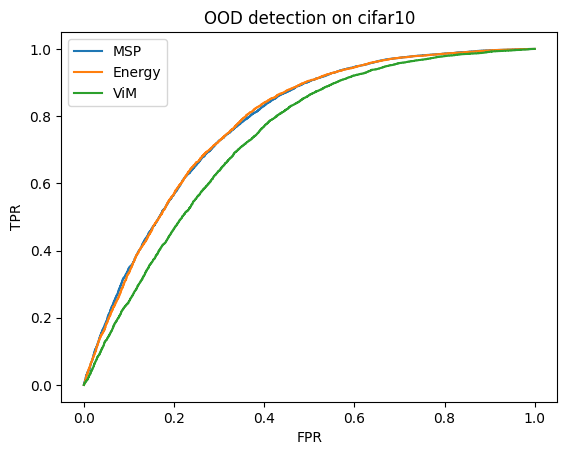

In [58]:
plt.figure()
plot_roc(score_msp(id_logits), score_msp(ood_logits), "MSP")
plot_roc(score_energy(id_logits), score_energy(ood_logits), "Energy")
plot_roc(
    score_vim(id_logits, id_feats, U_orth),
    score_vim(ood_logits, ood_feats, U_orth),
    "ViM"
)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("OOD detection on cifar10")
os.makedirs("results/img", exist_ok=True)
plt.savefig("results/img/OOD_cifar10")
plt.show()

In [39]:
ood_logits = collect_logits(model, ood_svhn_loader)
ood_feats  = collect_features(model, ood_svhn_loader)

results_svhn = {
    "MSP": eval_ood(score_msp(id_logits), score_msp(ood_logits)),
    "MaxLogit": eval_ood(score_maxlogit(id_logits), score_maxlogit(ood_logits)),
    "Energy": eval_ood(score_energy(id_logits), score_energy(ood_logits)),
    "Mahalanobis": eval_ood(
        score_mahalanobis(id_feats, mus, inv_cov),
        score_mahalanobis(ood_feats, mus, inv_cov)
    ),
    "ViM": eval_ood(
        score_vim(id_logits, id_feats, U_orth),
        score_vim(ood_logits, ood_feats, U_orth)
    )
}

In [43]:
df_svhn = pd.DataFrame(results_svhn).T
df_svhn

,AUROC,AUPR,FPR@95
MSP,0.818914,0.892777,0.4944
MaxLogit,0.820560,0.892810,0.4832
Energy,0.816240,0.887179,0.4778
Mahalanobis,0.819037,0.890681,0.5268
ViM,0.910182,0.954553,0.3652


In [44]:
df_cifar = pd.DataFrame(results_cifar10).T
df_cifar

,AUROC,AUPR,FPR@95
MSP,0.780883,0.736702,0.6125
MaxLogit,0.782357,0.737780,0.6121
Energy,0.781018,0.733601,0.6114
Mahalanobis,0.748398,0.702395,0.7298
ViM,0.735324,0.680681,0.6755


In [51]:
os.makedirs("results", exist_ok=True)
df_svhn.to_csv('results/results_svhn.csv', index=True)
df_cifar.to_csv('results/results_cifar.csv', index=True)

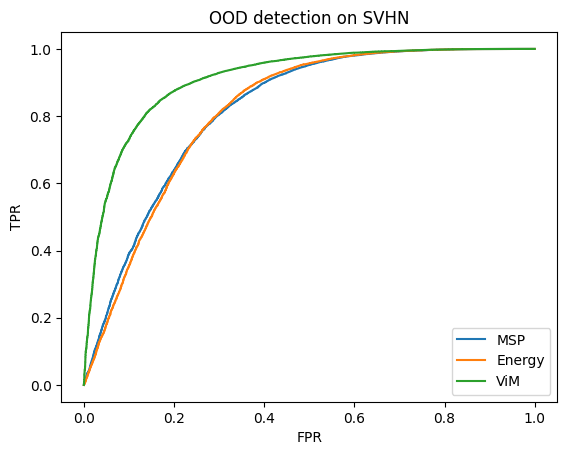

In [ ]:
plt.figure()
plot_roc(score_msp(id_logits), score_msp(ood_logits), "MSP")
plot_roc(score_energy(id_logits), score_energy(ood_logits), "Energy")
plot_roc(
    score_vim(id_logits, id_feats, U_orth),
    score_vim(ood_logits, ood_feats, U_orth),
    "ViM"
)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("OOD detection on SVHN")
os.makedirs("results/img", exist_ok=True)
plt.savefig("results/img/OOD_SVHN")
plt.show()

In [ ]:


plt.figure()
plot_roc(score_msp(id_logits), score_msp(ood_logits), "MSP")
plot_roc(score_energy(id_logits), score_energy(ood_logits), "Energy")
plot_roc(
    score_vim(id_logits, id_feats, U_orth),
    score_vim(ood_logits, ood_feats, U_orth),
    "ViM"
)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("OOD detection on SVHN")
os.makedirs("results/img", exist_ok=True)
plt.savefig("results/img/OOD_SVHN")
plt.show()